# Fake News Detection Using RNN

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png">

This notebook aims to classify fake news from real news using a recurrent neural network. To simplify the text preprocessing procedure, we will be using the built in functions from tensorflow instead of more established libraries like NLTK.

**Here are the results: **

* Accuracy on testing set: 0.9904231625835189
* Precision on testing set: 0.9879573876794813
* Recall on testing set: 0.9920930232558139

*Free free to provide me with feedbacks.  

**New update: confusion matrix is now expressed in terms of percentage rather than frequency.**


Image Source: https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png
Code is on my Github: https://github.com/therealcyberlord


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
plt.style.use('ggplot')

from google.colab import drive
import zipfile

In [2]:
import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Bidirectional, LSTM, Dropout, Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Read the data

In [4]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/fake news/archive.zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV file in the zip folder
    csv_filename = next(name for name in zip_ref.namelist() if name.endswith('.csv'))
    # Extract the CSV file to the current directory
    zip_ref.extract(csv_filename, path='/content')

# Read the csv file from the unzipped directory
df = pd.read_csv(f'/content/{csv_filename}')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking for null values

## EDA

In [5]:
df.head()

Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   
5           5  About Time! Christian Group Sues Amazon and SP...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
5  All we can say on this one is it s about time ...      1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71537 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  71537 non-null  int64 
 1   title       71537 non-null  object
 2   text        71537 non-null  object
 3   label       71537 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.7+ MB


Check out the distribution of fake news compare to real news

([<matplotlib.patches.Wedge at 0x7fd95e96ae00>,
 [Text(-1.1993655425032221, -0.039016604874742726, 'Fake'),
  Text(1.1993655425032221, 0.03901660487474258, 'True')],
 [Text(-0.6996298997935462, -0.022759686176933257, '51.0%'),
  Text(0.6996298997935462, 0.022759686176933167, '49.0%')])

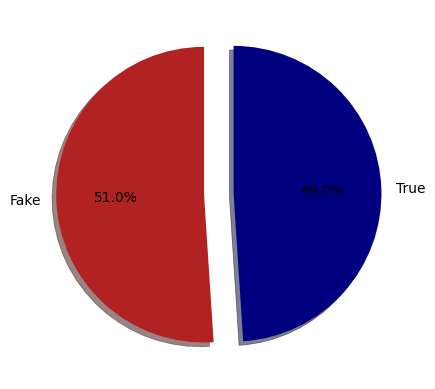

In [7]:
# Checking if our df is well balanced
label_size = [df['label'].sum(),len(df['label'])-df['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

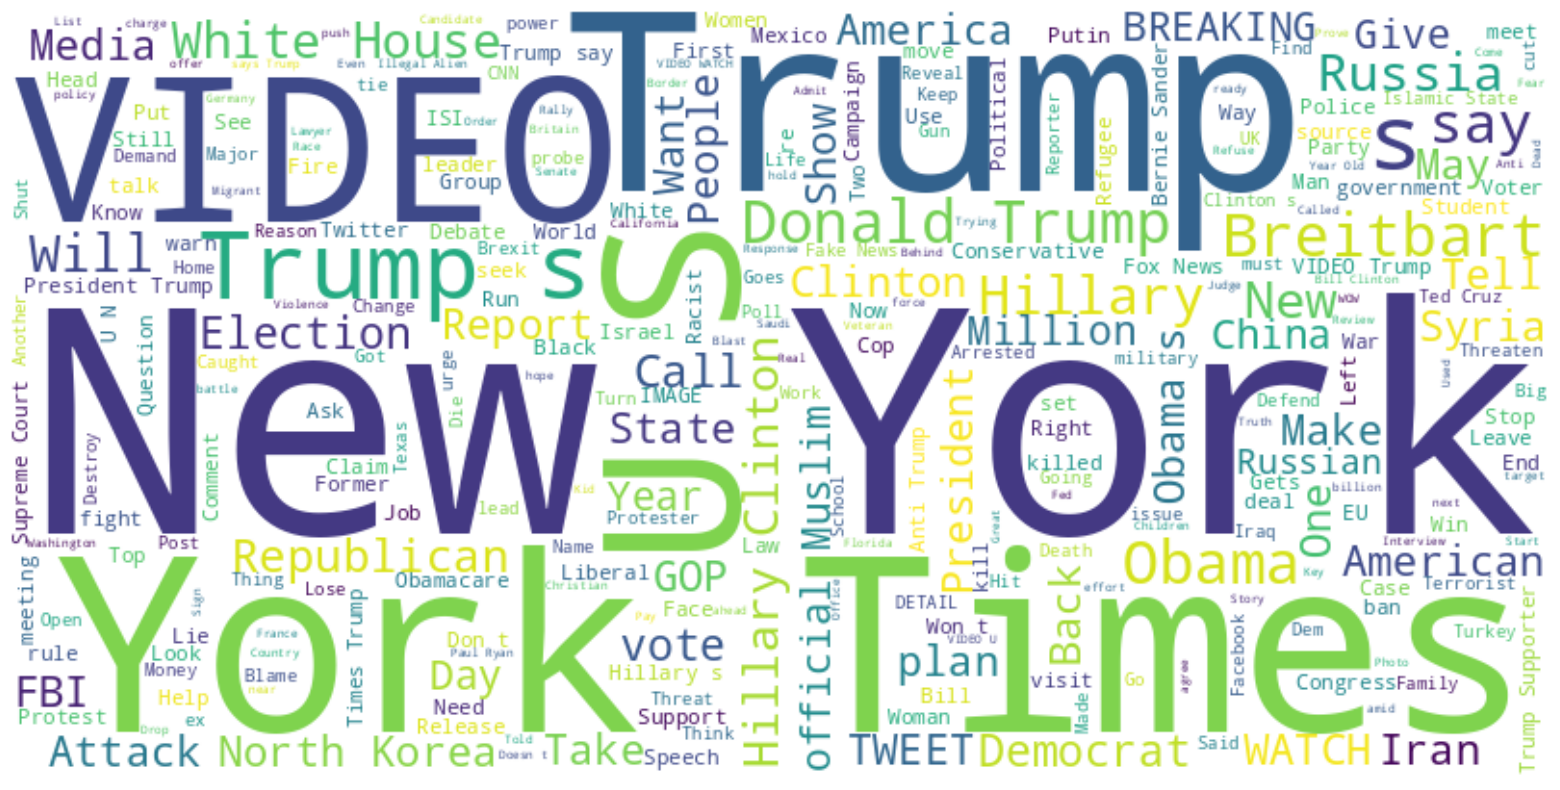

In [8]:
titles = ' '.join(title for title in df['title'])
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

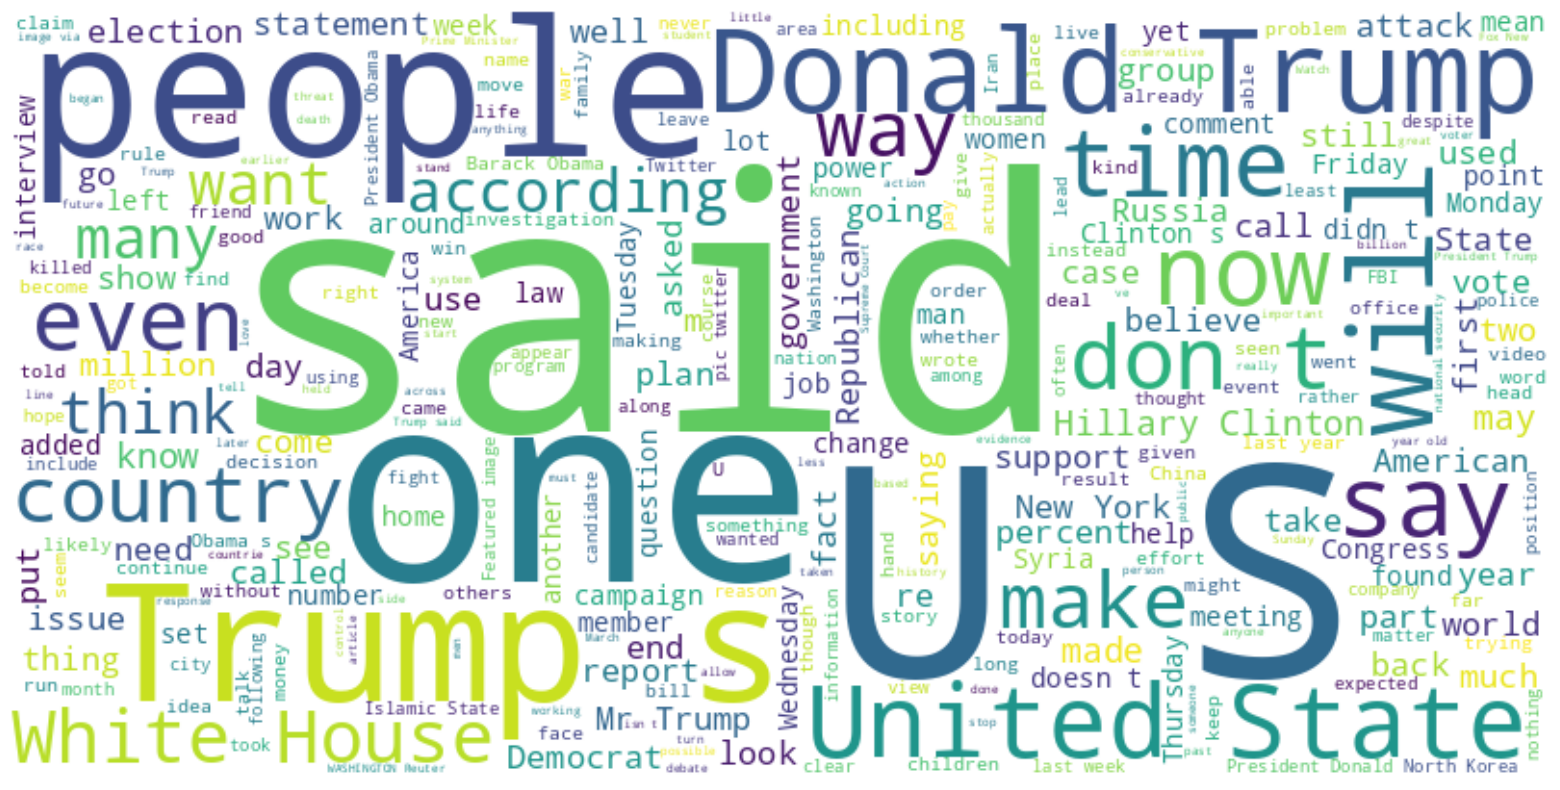

In [9]:
titles = ' '.join(title for title in df['text'])
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Split into training and testing

In [10]:
features = df['text']
targets = df['label']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

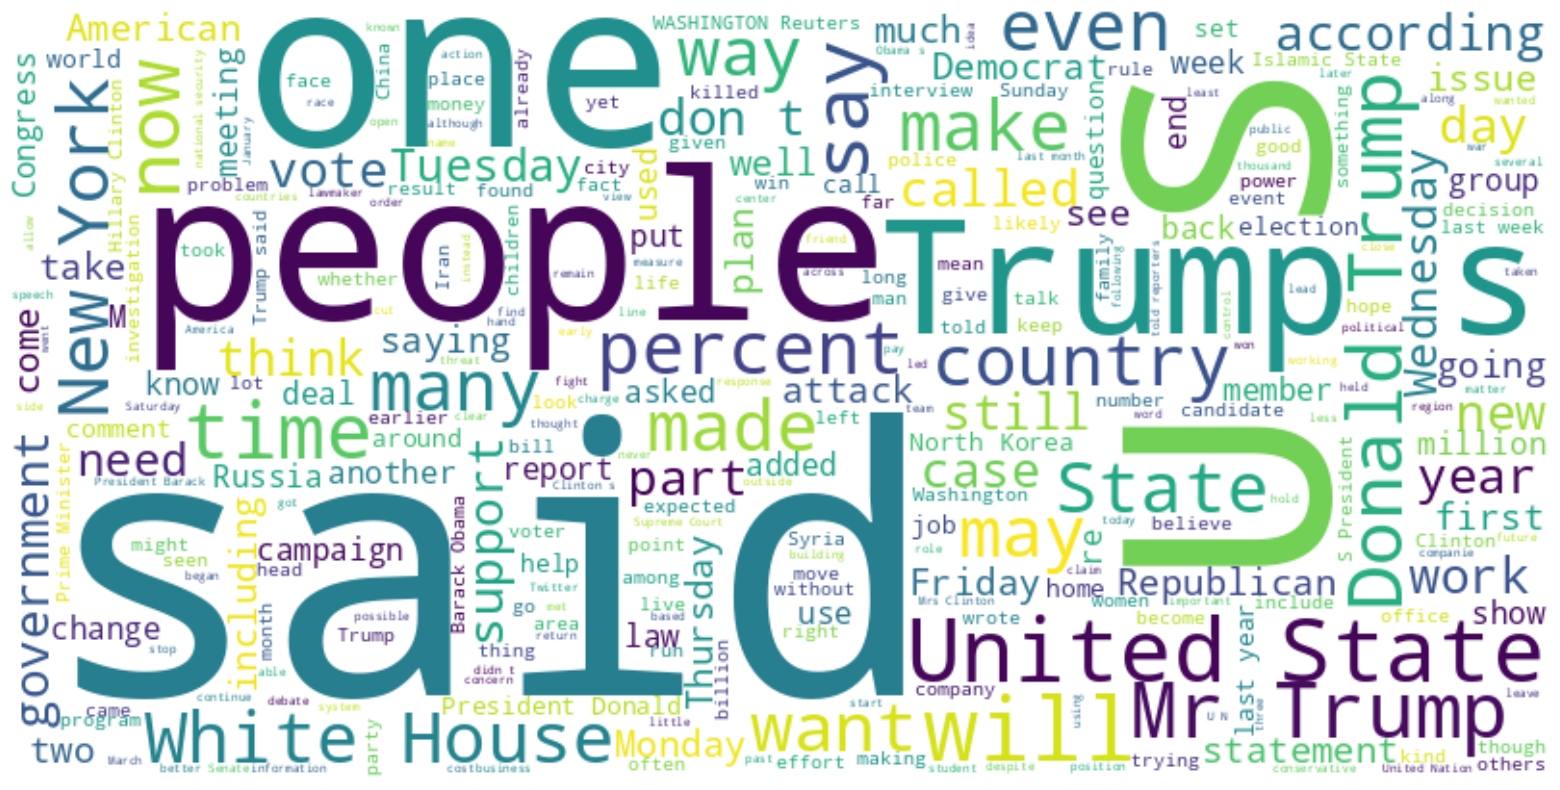

In [11]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]
fake_texts = ' '.join(text for text in fake_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

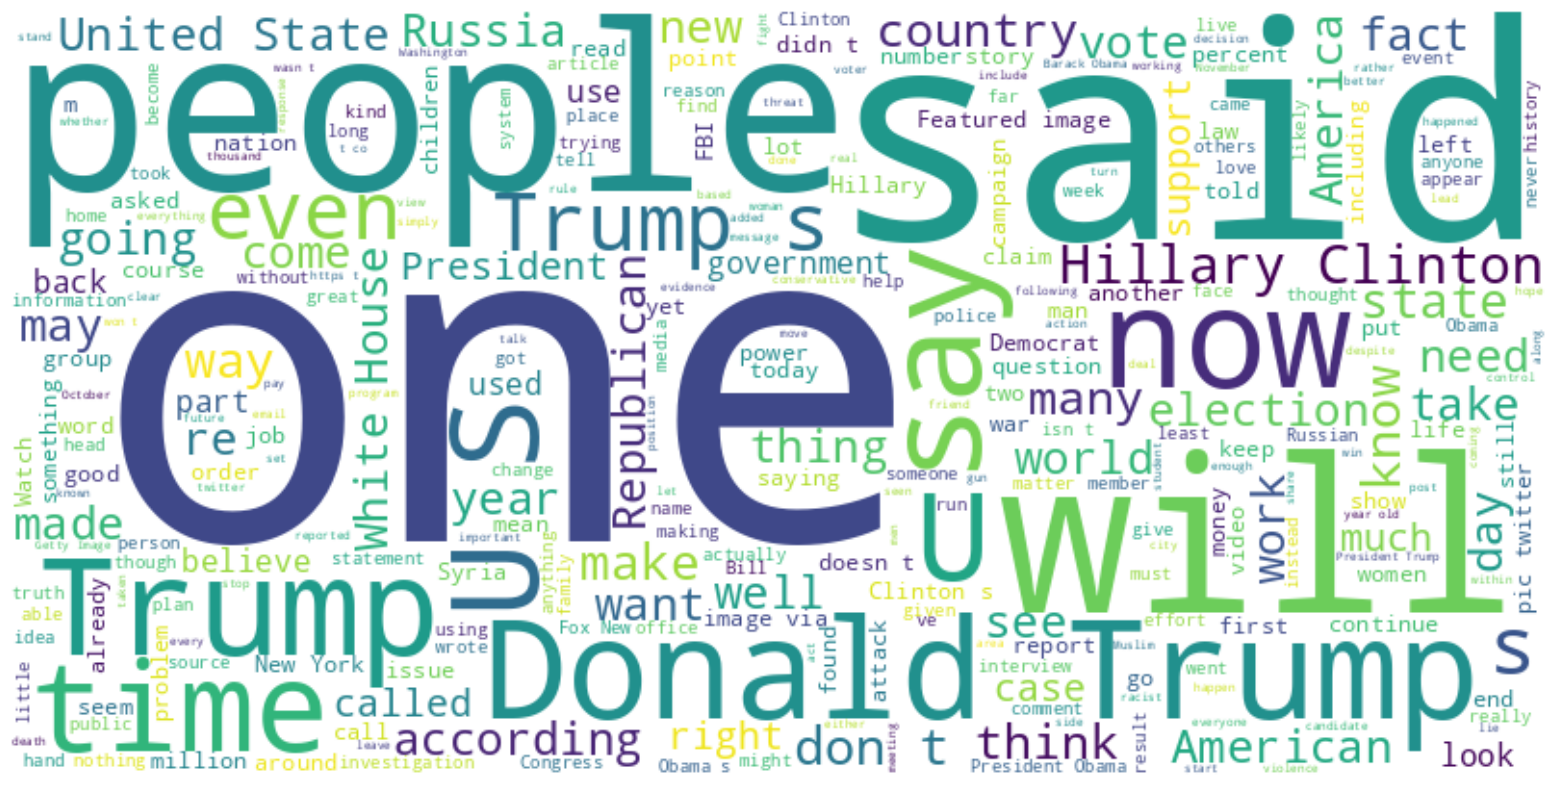

In [12]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]
fake_texts = ' '.join(text for text in real_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Machine Learning

### RNN

Normalizing our data: lower case, get rid of extra spaces, and url links.

In [13]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [14]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data.

In [15]:
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article

In [16]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

We are going to use early stop, which stops when the validation loss no longer improve.

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1717/1717 [==============================] - 171s 91ms/step - loss: 0.2960 - accuracy: 0.8555 - val_loss: 0.1709 - val_accuracy: 0.9266
Epoch 2/10
1717/1717 [==============================] - 70s 41ms/step - loss: 0.1267 - accuracy: 0.9567 - val_loss: 0.1407 - val_accuracy: 0.9453
Epoch 3/10
1717/1717 [==============================] - 64s 38ms/step - loss: 0.0844 - accuracy: 0.9739 - val_loss: 0.1386 - val_accuracy: 0.9500
Epoch 4/10
1717/1717 [==============================] - 63s 37ms/step - loss: 0.0546 - accuracy: 0.9837 - val_loss: 0.1453 - val_accuracy: 0.9560
Epoch 5/10
1717/1717 [==============================] - 63s 37ms/step - loss: 0.0385 - accuracy: 0.9892 - val_loss: 0.1797 - val_accuracy: 0.9464


Visualize our training over time

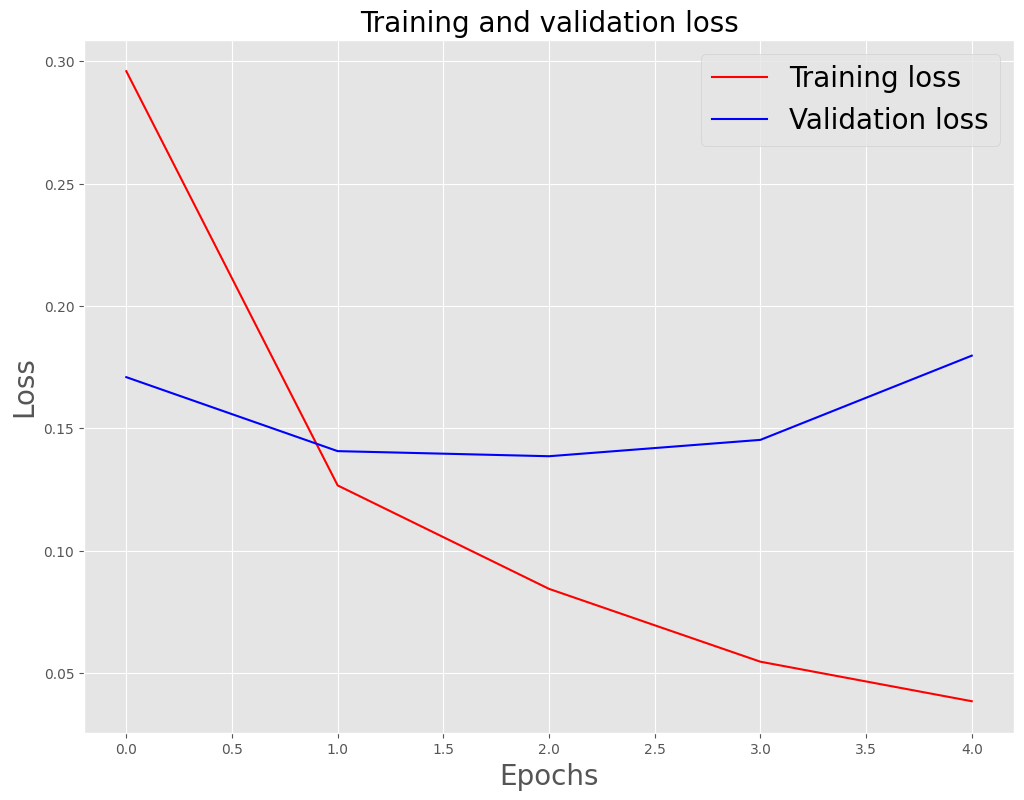

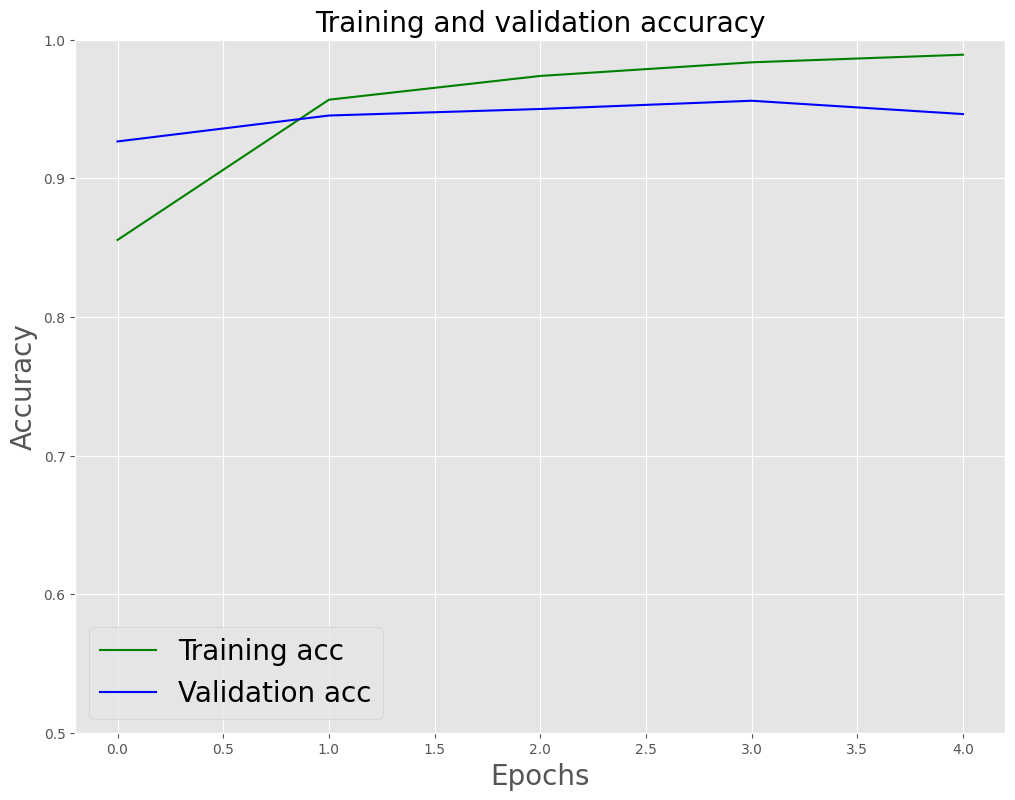

In [19]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set

In [20]:
model.evaluate(X_test, y_test)

448/448 [==============================] - 7s 16ms/step - loss: 0.1378 - accuracy: 0.9495


[0.13781845569610596, 0.9495387077331543]

In [21]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

448/448 [==============================] - 7s 12ms/step


In [22]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1 score on testing set:', f1_score(binary_predictions, y_test))

Accuracy on testing set: 0.949538719597428
Precision on testing set: 0.9323671497584541
Recall on testing set: 0.9667954773150136
F1 score on testing set: 0.9492692523889826


Confusion matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

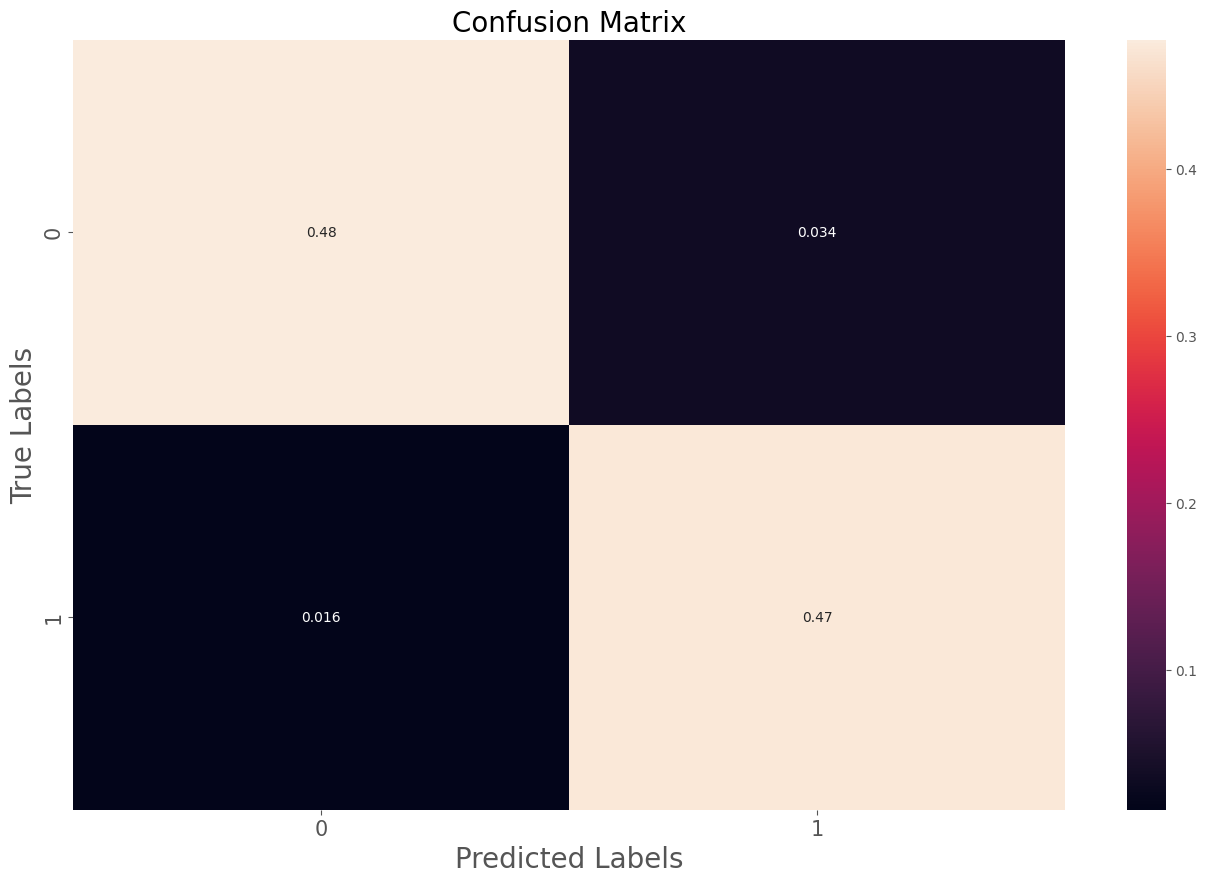

In [23]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

### LSTM

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify = targets, random_state = 10)

In [25]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 276473


In [26]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [27]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 128)          35388544  
                                                                 
 bidirectional_2 (Bidirecti  (None, 512, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

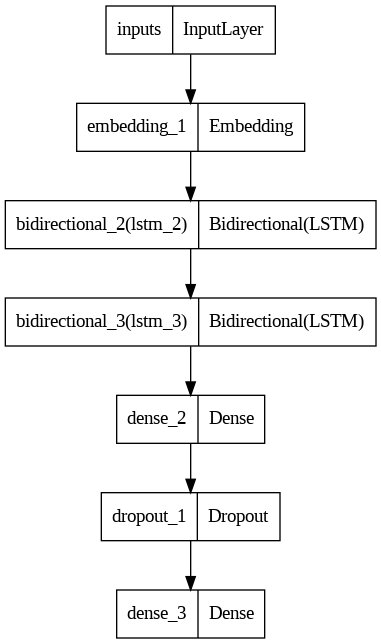

In [28]:
#plot the model architecture
tf.keras.utils.plot_model(model)

In [29]:
history = model.fit(X_train_seq, y_train, epochs=10,
                    validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/10
671/671 [==============================] - 188s 269ms/step - loss: 0.2841 - accuracy: 0.8791 - val_loss: 0.1207 - val_accuracy: 0.9543
Epoch 2/10
671/671 [==============================] - 126s 188ms/step - loss: 0.0791 - accuracy: 0.9761 - val_loss: 0.0963 - val_accuracy: 0.9680
Epoch 3/10
671/671 [==============================] - 101s 151ms/step - loss: 0.0358 - accuracy: 0.9903 - val_loss: 0.1052 - val_accuracy: 0.9651
Epoch 4/10
671/671 [==============================] - 91s 135ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 0.1130 - val_accuracy: 0.9692
Epoch 5/10
671/671 [==============================] - 81s 120ms/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.1305 - val_accuracy: 0.9696
Epoch 6/10
671/671 [==============================] - 77s 115ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.1295 - val_accuracy: 0.9700
Epoch 7/10
671/671 [==============================] - 80s 119ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.1484 - val

In [30]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 [==============================] - 16s 27ms/step
Test Loss: 0.15595558285713196
Test Accuracy: 0.9693039059638977


In [31]:
## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8757
           1       0.96      0.98      0.97      9128

    accuracy                           0.97     17885
   macro avg       0.97      0.97      0.97     17885
weighted avg       0.97      0.97      0.97     17885



Text(70.72222222222221, 0.5, 'Real Labels')

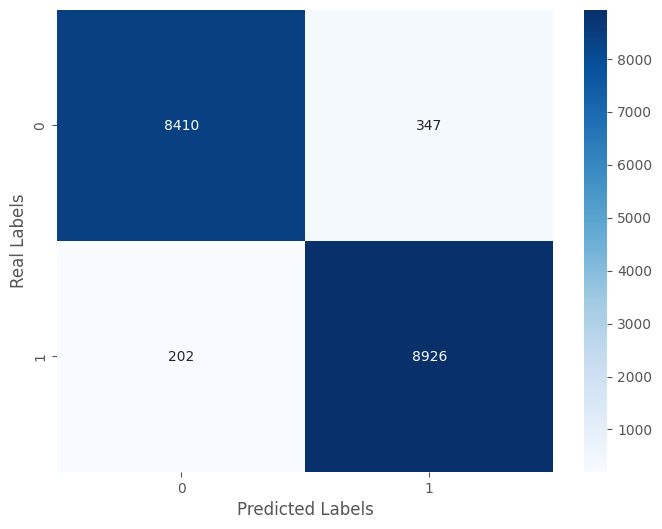

In [32]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## Logistic Regression

In [33]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

In [34]:
lr = LogisticRegression()
lr.fit(xv_train,y_train)

LogisticRegression()

In [35]:
pred_lr=lr.predict(xv_test)

In [36]:
lr.score(xv_test, y_test)

0.9456527816606094

In [37]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      8757
           1       0.94      0.96      0.95      9128

    accuracy                           0.95     17885
   macro avg       0.95      0.95      0.95     17885
weighted avg       0.95      0.95      0.95     17885



## Random Forest Classifier

In [38]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [39]:
rfc.score(xv_test, y_test)

0.9285993849594633

In [40]:
pred_rfc = rfc.predict(xv_test)

In [41]:
pred_rfc = rfc.predict(xv_test)
rfc.score(xv_test, y_test)

0.9285993849594633

In [42]:
rfc.score(xv_test, y_test)

0.9285993849594633

In [43]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      8757
           1       0.92      0.95      0.93      9128

    accuracy                           0.93     17885
   macro avg       0.93      0.93      0.93     17885
weighted avg       0.93      0.93      0.93     17885

